<a href="https://colab.research.google.com/github/SwayamK9/IWT_PROJECT/blob/main/ml_28_nov_openbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Q. Problem Statement

You are a data scientist at "FinSecure," a peer-to-peer lending company that connects borrowers with investors. The company's success hinges on its ability to accurately assess the risk of a borrower defaulting on their loan. A high rate of loan defaults not only results in financial losses for investors but also damages the company's reputation and trust in the marketplace.

The loan approval team currently relies on a manual, scorecard-based system to approve or deny loan applications. However, this process is slow and may not be capturing complex, non-linear patterns in the data that could indicate a higher risk of default. The leadership team wants to develop a data-driven system to predict the likelihood of a loan being paid back in full.

Your task is to analyze the provided loan application dataset and build a predictive model to identify loans that are likely to default. You are free to choose any architecture you have learned in class.


## The Dataset

You are provided with a dataset named loan_data.csv. It contains historical data on loan applications, including applicant details and whether the loan was ultimately paid back.

- id: A unique identifier for the loan application.
- annual_income: The annual income of the borrower.
- debt_to_income_ratio: The ratio of the borrower's total debt to their annual income.
- credit_score: The credit score of the borrower.
- loan_amount: The total amount of the loan requested.
- interest_rate: The interest rate assigned to the loan.
- gender: The gender of the borrower.
- marital_status: The marital status of the borrower.
- education_level: The highest level of education attained by the borrower.
- employment_status: The employment status of the borrower.
- loan_purpose: The stated purpose of the loan (e.g., debt consolidation, home improvement).
- grade, subgrade: A loan grade and subgrade assigned by FinSecure, indicating risk.
- loan_paid_back: The target variable; indicates whether the loan was paid back (1) or not (0).

## Your Deliverables

**Section 1: Problem Formulation & Target Variable Analysis**

The business problem is to predict loan default. The dataset provides a target variable "loan_paid_back". Your first task is to understand what a "default" means in this context.

**Section 2: Feature Engineering & Preprocessing Pipeline**

Based on the raw data, you have to design a comprehensive preprocessing pipeline that will handle the following:
- Missing values (if any are present).
- Categorical feature encoding for columns like "loan_purpose" and "education_level" using your choice of encoder (e.g., One-Hot Encoding, Ordinal Encoding).
- Feature scaling / normalization for numerical columns like "annual_income" and "loan_amount"

Also, keep in mind that you have split your data into training set and testing set.

**Section 3: Model Development and Tuning**

For each sample (id) in your test set, your model must predict a probability for the "loan_paid_back" variable. The goal should be to maximize the area under the ROC curve (AUC) between the predicted probability and the actual value.

**Section 4: Subgroup Analysis**

The loan approval team needs to ensure the model is fair and doesn't disproportionately penalize certain groups. Calculate and present the following metrics for your final model (using your chosen threshold) across these subgroups:
- By education_level: (Report on each level present in the data)
- By loan_purpose: (Report on the top 3 and bottom 3 performing purposes)

Metrics to report: AUC

In [20]:
# ============================================================
# Section 0: Imports, Helpers & Data Loading
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# -------------------------
# Pretty-print helpers
# -------------------------

def section_title(text: str):
    bar = "═" * len(text)
    print(f"\n\033[1m{bar}\n{text}\n{bar}\033[0m")

def sub_title(text: str):
    print(f"\n\033[1m▶ {text}\033[0m")

def style_table(df: pd.DataFrame, caption: str = ""):
    """
    Nicely styled HTML table for Colab.
    Hides the index and formats floats to 4 decimals.
    """
    styler = (
        df.style
        .set_caption(caption)
        .set_table_styles(
            [
                {
                    "selector": "caption",
                    "props": [
                        ("caption-side", "top"),
                        ("font-size", "16px"),
                        ("font-weight", "bold"),
                        ("text-align", "left"),
                        ("margin-bottom", "8px"),
                    ],
                },
                {
                    "selector": "th",
                    "props": [
                        ("background-color", "#f2f2f2"),
                        ("font-weight", "bold"),
                        ("padding", "8px"),
                        ("border-bottom", "1px solid #ddd"),
                    ],
                },
                {
                    "selector": "td",
                    "props": [
                        ("padding", "6px"),
                        ("border-bottom", "1px solid #eee"),
                    ],
                },
            ]
        )
        .format(precision=4)
        .hide(axis="index")
    )
    display(styler)

# -------------------------
# Load dataset
# -------------------------

section_title("Section 0: Imports & Data Loading")

# Adjust the path if needed (e.g., "/content/loan_data.csv" in Colab)
df = pd.read_csv("loan_data.csv")

print(f"✅ Dataset loaded.")
print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")

sub_title("Sample rows")
display(df.head())



═════════════════════════════════
Section 0: Imports & Data Loading
═════════════════════════════════
✅ Dataset loaded.
   Shape: 268,114 rows × 13 columns

▶ Sample rows


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


In [21]:
# ============================================================
# Section 1: Target Variable Analysis
# ============================================================

section_title("Section 1: Target Variable Analysis")

target_col = "loan_paid_back"

sub_title("Target value counts")
display(df[target_col].value_counts().to_frame(name="count"))

sub_title("Target proportions")
display(df[target_col].value_counts(normalize=True).to_frame(name="proportion"))

print("\nInterpretation (example):")
print("Dataset appears imbalanced (e.g., majority paid back vs minority default).")



═══════════════════════════════════
Section 1: Target Variable Analysis
═══════════════════════════════════

▶ Target value counts


,count
loan_paid_back,
1,214068
0,54046



▶ Target proportions


,proportion
loan_paid_back,
1,0.798422
0,0.201578



Interpretation (example):
Dataset appears imbalanced (e.g., majority paid back vs minority default).


In [22]:
# ============================================================
# Section 2: Feature Engineering & Preprocessing
# ============================================================

section_title("Section 2: Feature Engineering & Preprocessing")

# Separate features and target
X = df.drop(columns=[target_col, "id"])
y = df[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42,
)

print("✅ Train/test split completed:")
print(f"   Train set: {X_train.shape[0]:,} rows × {X_train.shape[1]:,} features")
print(f"   Test set : {X_test.shape[0]:,} rows × {X_test.shape[1]:,} features")

# FEATURE CATEGORIES
numeric_features = [
    "annual_income",
    "debt_to_income_ratio",
    "credit_score",
    "loan_amount",
    "interest_rate",
]

categorical_features = [
    "gender",
    "marital_status",
    "education_level",
    "employment_status",
    "loan_purpose",
    "grade_subgrade",
]

sub_title("Numeric features")
print(numeric_features)

sub_title("Categorical features")
print(categorical_features)

# NUMERIC PIPELINE
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# CATEGORICAL PIPELINE
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# FINAL PREPROCESSOR
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print("\n✅ Preprocessing pipeline created.")



══════════════════════════════════════════════
Section 2: Feature Engineering & Preprocessing
══════════════════════════════════════════════
✅ Train/test split completed:
   Train set: 214,491 rows × 11 features
   Test set : 53,623 rows × 11 features

▶ Numeric features
['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']

▶ Categorical features
['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']

✅ Preprocessing pipeline created.


In [17]:
# ============================================================
# Section 3: Model Development and Evaluation
# ============================================================

section_title("Section 3: Model Development and Evaluation")

# --- Logistic Regression ---
sub_title("Training Logistic Regression")

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs",
)

log_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", log_reg),
    ]
)

log_clf.fit(X_train, y_train)
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
auc_log = roc_auc_score(y_test, y_proba_log)

print(f"Logistic Regression ROC AUC: {auc_log:.4f}")

# --- Gradient Boosting ---
sub_title("Training Gradient Boosting")

gb_model = GradientBoostingClassifier(random_state=42)

gb_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", gb_model),
    ]
)

gb_clf.fit(X_train, y_train)
y_proba_gb = gb_clf.predict_proba(X_test)[:, 1]
auc_gb = roc_auc_score(y_test, y_proba_gb)

print(f"Gradient Boosting ROC AUC: {auc_gb:.4f}")

# --- Compare models in a nice table ---
model_results = pd.DataFrame(
    {
        "Model": ["Logistic Regression", "Gradient Boosting"],
        "Test ROC AUC": [auc_log, auc_gb],
    }
)

sub_title("Model comparison on Test AUC")
style_table(model_results, caption="Model Performance (Test ROC AUC)")

# --- Select best model ---
if auc_gb > auc_log:
    best_model_name = "Gradient Boosting"
    best_model = gb_clf
    y_proba_test = y_proba_gb
else:
    best_model_name = "Logistic Regression"
    best_model = log_clf
    y_proba_test = y_proba_log

print(f"\n✅ Final selected model: \033[1m{best_model_name}\033[0m")

# === Optimal Threshold ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
best_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_idx]

print(f"\nBest decision threshold (Youden's J): {best_threshold:.4f}")



═══════════════════════════════════════════
Section 3: Model Development and Evaluation
═══════════════════════════════════════════

▶ Training Logistic Regression
Logistic Regression ROC AUC: 0.9122

▶ Training Gradient Boosting
Gradient Boosting ROC AUC: 0.9162

▶ Model comparison on Test AUC


Model,Test ROC AUC
Logistic Regression,0.9122
Gradient Boosting,0.9162



✅ Final selected model: Gradient Boosting

Best decision threshold (Youden's J): 0.8259



════════════════════════════════════
Section 3.1: ROC Curve – Final Model
════════════════════════════════════


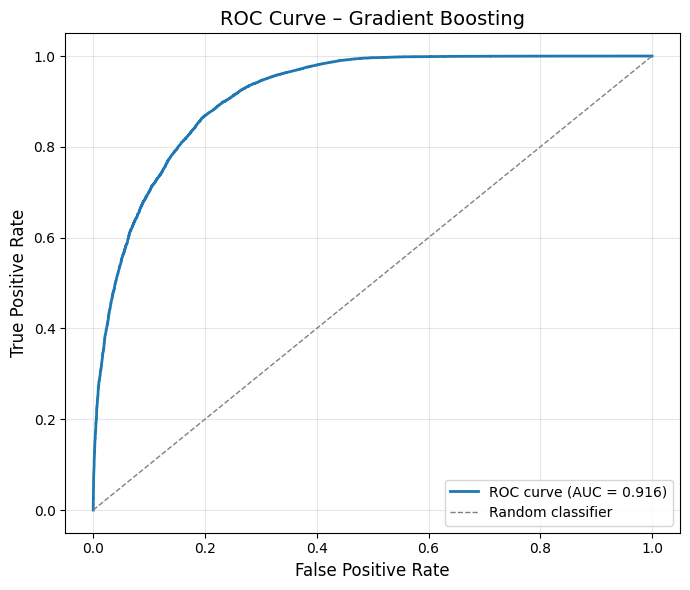

In [18]:
# ============================================================
# [REQUIRED] AUC Curve Plot (Final Model)
# ============================================================

section_title("Section 3.1: ROC Curve – Final Model")

fpr, tpr, _ = roc_curve(y_test, y_proba_test)
test_auc = roc_auc_score(y_test, y_proba_test)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random classifier", linewidth=1)

plt.title(f"ROC Curve – {best_model_name}", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [19]:
# ============================================================
# Section 4: Subgroup AUC Metrics
# ============================================================

section_title("Section 4: Subgroup AUC Metrics")

def subgroup_auc(df_with_preds: pd.DataFrame, group: str) -> pd.DataFrame:
    """
    Compute ROC AUC for each value of 'group' using
    columns: 'loan_paid_back' and 'y_proba'.
    """
    rows = []
    for value, sub_df in df_with_preds.groupby(group):
        if sub_df["loan_paid_back"].nunique() < 2:
            auc_val = np.nan
        else:
            auc_val = roc_auc_score(sub_df["loan_paid_back"], sub_df["y_proba"])
        rows.append((value, auc_val, len(sub_df)))

    result = pd.DataFrame(rows, columns=[group, "AUC", "n_samples"])
    result = result.sort_values("AUC", ascending=False).reset_index(drop=True)
    return result

# Add predictions to test set
X_test_meta = X_test.copy()
X_test_meta["loan_paid_back"] = y_test.values
X_test_meta["y_proba"] = y_proba_test

# === EDUCATION LEVEL ===
if "education_level" in X_test_meta.columns:
    sub_title("AUC by education_level")
    edu_results = subgroup_auc(X_test_meta, "education_level")
    style_table(edu_results, caption="Subgroup AUC by Education Level")

    sub_title("Top 3 education_level (by AUC)")
    style_table(edu_results.head(3), caption="Top 3 Education Levels")

    sub_title("Bottom 3 education_level (by AUC)")
    style_table(edu_results.tail(3), caption="Bottom 3 Education Levels")
else:
    print("Column 'education_level' not found in X_test. Skipping education-level analysis.")

# === LOAN PURPOSE ===
if "loan_purpose" in X_test_meta.columns:
    sub_title("AUC by loan_purpose")
    purpose_results = subgroup_auc(X_test_meta, "loan_purpose")
    style_table(purpose_results, caption="Subgroup AUC by Loan Purpose")

    sub_title("Top 3 loan_purpose (by AUC)")
    style_table(purpose_results.head(3), caption="Top 3 Loan Purposes")

    sub_title("Bottom 3 loan_purpose (by AUC)")
    style_table(purpose_results.tail(3), caption="Bottom 3 Loan Purposes")
else:
    print("Column 'loan_purpose' not found in X_test. Skipping loan-purpose analysis.")



═══════════════════════════════
Section 4: Subgroup AUC Metrics
═══════════════════════════════

▶ AUC by education_level


education_level,AUC,n_samples
Other,0.9270,2336
Bachelor's,0.9171,25263
High School,0.9145,16701
Master's,0.9137,8341
PhD,0.9109,982



▶ Top 3 education_level (by AUC)


education_level,AUC,n_samples
Other,0.9270,2336
Bachelor's,0.9171,25263
High School,0.9145,16701



▶ Bottom 3 education_level (by AUC)


education_level,AUC,n_samples
High School,0.9145,16701
Master's,0.9137,8341
PhD,0.9109,982



▶ AUC by loan_purpose


loan_purpose,AUC,n_samples
Education,0.9288,3202
Medical,0.9226,2088
Vacation,0.9217,760
Home,0.9191,4027
Other,0.9173,5785
Business,0.9159,3091
Debt consolidation,0.9153,29317
Car,0.9059,5353



▶ Top 3 loan_purpose (by AUC)


loan_purpose,AUC,n_samples
Education,0.9288,3202
Medical,0.9226,2088
Vacation,0.9217,760



▶ Bottom 3 loan_purpose (by AUC)


loan_purpose,AUC,n_samples
Business,0.9159,3091
Debt consolidation,0.9153,29317
Car,0.9059,5353
